# ERA5 Climate Data Preprocessing


This notebook handles the preprocessing of ERA5 reanalysis climate data for the Azores Free Technological Zone digital twin project. The preprocessing pipeline includes:- **Temporal**: Hourly ERA5 reanalysis data

- **Resolution**: 0.25° × 0.25° grid spacing

## Key Operations:- **14 Variables**: 11 meteorological + 3 wave parameters

1. **Data Integration**: Combine individual ERA5 files into unified training/test datasets- **Spatial Coverage**: Azores region (23°W-33°W, 35°N-41°N)

2. **Quality Assessment**: Analyze missing values and data completeness## Dataset Structure:

3. **Spatial Visualization**: Display data coverage and geographic distribution

4. **Temporal Analysis**: Examine variable evolution over time5. **Data Validation**: Ensure data integrity and format consistency

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from IPython.display import display, clear_output
import xarray as xr
import glob
import os
import pandas as pd

# 1. Dataset Variables and Structure

> **Note**: Wave variables serve as both input features and target variables for prediction tasks.

## 1.1 Variable Definitions

The ERA5 dataset contains **17 total variables**: 3 coordinate references (indexes) + 14 physical variables (11 meteorological + 3 wave parameters)

### Coordinate Variables:

- `valid_time`: Time of forecasted data <br>

- `latitude`: Latitude coordinates [degrees North]<br>

- `longitude`: Longitude coordinates [degrees West]<br>


### Meteorological Variables (11):

| `u10` | U-component of 10m wind | m/s |<br>
| `v10` | V-component of 10m wind | m/s |<br>
| `d2m` | 2-meter dew point temperature | K |<br>
| `t2m` | 2-meter temperature | K |<br>
| `msl` | Mean sea level pressure | Pa |<br>
| `sst` | Sea surface temperature | K |<br>
| `skt` | Skin temperature | K |<br>
| `sp` | Surface pressure | Pa |<br>
| `ssrd` | Surface solar radiation downwards | J/m² |<br>
| `strd` | Surface thermal radiation downwards | J/m² |<br>
| `tp` | Total precipitation | m |<br>


### Wave Variables (3) - *Target Variables*:

| `mwd` | Mean wave direction | degrees |<br>
| `mwp` | Mean wave period | seconds |<br>
| `swh` | Significant wave height | meters |<br>



# 2. Data Integration Pipeline


## 2.1 Combine Individual Point FilesMerge individual ERA5 point files into unified training and test datasets for efficient processing.

In [11]:
# --------------------- Join all Data into one Dataset ---------------------
if False:
    folder = "dataset_test" # or "dataset_train"

    files = sorted(glob.glob(f"{folder}/ERA5_*.nc"))
    datasets = [xr.open_dataset(f) for f in files]
    combined = xr.concat(datasets, dim="point")

    # Assign lat/lon from metadata
    combined = combined.assign_coords({
        "latitude": ("point", [ds.latitude.values for ds in datasets]),
        "longitude": ("point", [ds.longitude.values for ds in datasets]),
    })



    combined_path = os.path.join(folder, f"combined.nc")
    combined.to_netcdf(combined_path)


## 2.2 Data Quality Assessment
Analyze missing values


In [12]:
# --------------------- Pre-Processment: Evaluating Missing Values ---------------------

folder = "dataset_train"  # adjust your folder path

ds = xr.open_dataset(f"{folder}/combined.nc")
ds.close()


nan_count = ds.to_dataframe().isna().sum()
nan_percent = nan_count / ds.to_dataframe().shape[0] * 100
#print(pd.concat([nan_count, nan_percent], axis=1, keys=["NaN count", "%"]))
print(np.sum(nan_count))



0


# 3. Dataset Information and Visualization


## 3.1 Dataset Structure OverviewDisplay comprehensive information about dataset dimensions, variables, and metadata.

In [13]:
# --------------------- About the Dataset ---------------------
print(ds.dims)
print(ds.data_vars)
print(ds.attrs)

FrozenMappingWarningOnValuesAccess({'point': 105, 'valid_time': 6624})
Data variables:
    u10      (point, valid_time) float32 3MB -4.633 -4.798 -4.5 ... 3.274 2.78
    v10      (point, valid_time) float32 3MB 11.89 12.0 13.08 ... 4.875 5.161
    d2m      (point, valid_time) float32 3MB 288.7 288.8 288.8 ... 294.5 294.5
    t2m      (point, valid_time) float32 3MB 293.4 293.3 293.3 ... 295.5 295.5
    msl      (point, valid_time) float32 3MB 1.019e+05 1.019e+05 ... 1.022e+05
    sst      (point, valid_time) float32 3MB 292.8 292.8 292.8 ... 294.8 294.8
    skt      (point, valid_time) float32 3MB 293.1 293.1 293.1 ... 294.7 294.6
    sp       (point, valid_time) float32 3MB 1.019e+05 1.019e+05 ... 1.022e+05
    ssrd     (point, valid_time) float32 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    strd     (point, valid_time) float32 3MB 1.325e+06 1.266e+06 ... 1.403e+06
    tp       (point, valid_time) float32 3MB 2.861e-06 0.0 ... 7.677e-05
    mwd      (point, valid_time) float32 3MB 177.2 17

## 3.2 Spatial Coverage Visualization
Visualize the geographic distribution of training (green) and test (red) data points across the Azores region.

c:\Users\berna\anaconda3\envs\dataz\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


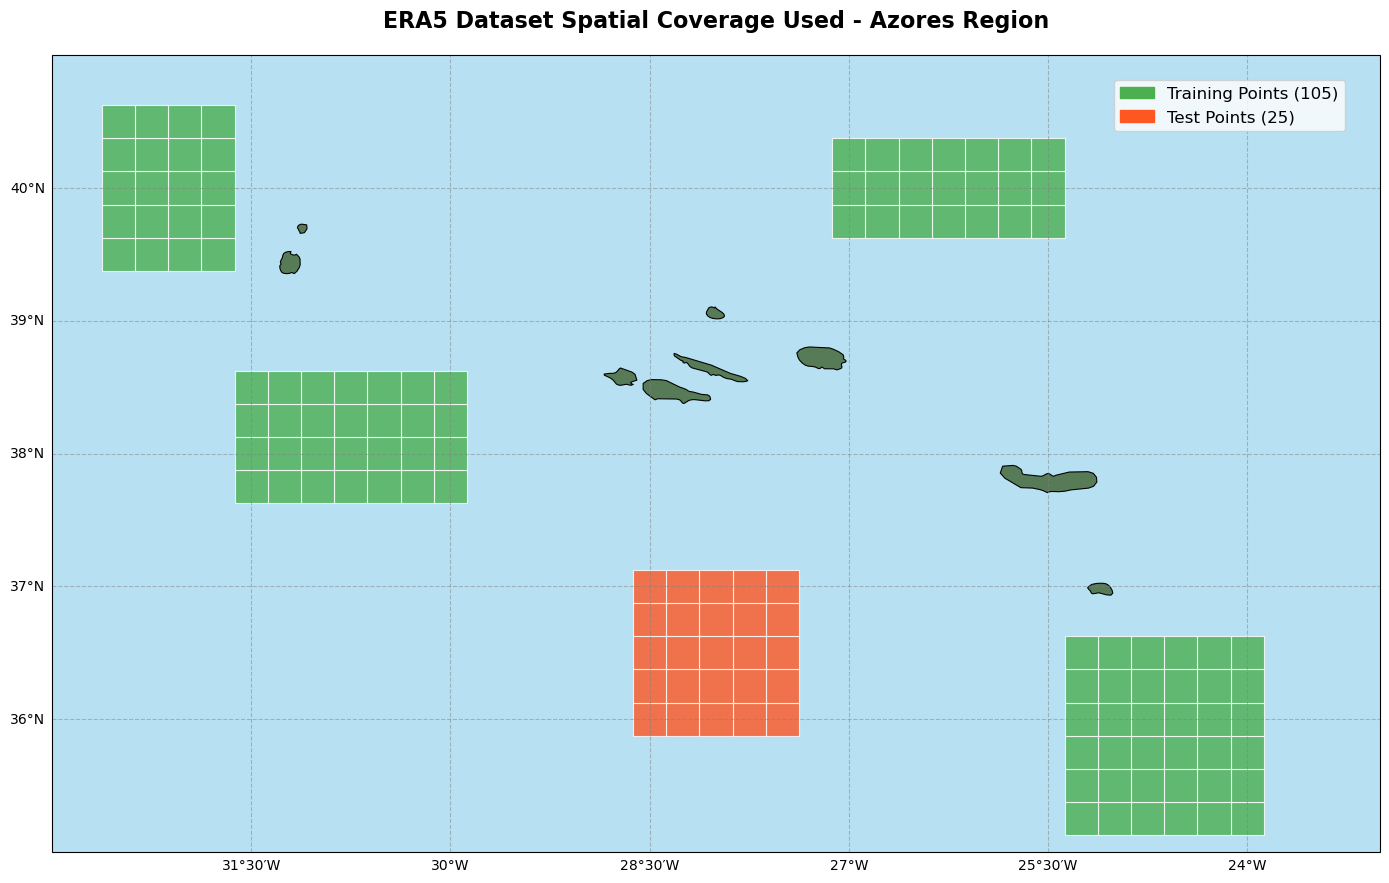

In [14]:
# Load datasets
folder_train = "dataset_train"  # adjust your folder path
folder_test = "dataset_test"   # adjust your folder path

ds_train = xr.open_dataset(f"{folder_train}/combined.nc")
ds_test = xr.open_dataset(f"{folder_test}/combined.nc")

# Extract coordinates
lats_train = ds_train.latitude.values
lons_train = ds_train.longitude.values
lats_test = ds_test.latitude.values  
lons_test = ds_test.longitude.values

# Calculate grid spacing
all_lats = np.unique(np.concatenate([lats_train, lats_test]))
all_lons = np.unique(np.concatenate([lons_train, lons_test]))

lat_spacing = np.min(np.diff(all_lats)) if len(all_lats) > 1 else 0.25
lon_spacing = np.min(np.diff(all_lons)) if len(all_lons) > 1 else 0.25

# Create map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set geographic extent (Azores region with buffer)
ax.set_extent([-33, -23, 35, 41], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor="#2d5a2d", alpha=0.8)  # Dark green land
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='#87ceeb', alpha=0.6)  # Light blue ocean

# Add gridlines with better formatting
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                  alpha=0.5, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Color scheme
train_color = "#4CAF50"  # Green for training
test_color = "#FF5722"   # Orange-red for test

# Draw training data points
for lon, lat in zip(lons_train, lats_train):
    rect = patches.Rectangle(
        (lon - lon_spacing/2, lat - lat_spacing/2),
        lon_spacing, lat_spacing,
        facecolor=train_color,
        alpha=0.8,
        edgecolor='white',
        linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

# Draw test data points
for lon, lat in zip(lons_test, lats_test):
    rect = patches.Rectangle(
        (lon - lon_spacing/2, lat - lat_spacing/2),
        lon_spacing, lat_spacing,
        facecolor=test_color,
        alpha=0.8,
        edgecolor='white',
        linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

# Add legend
train_patch = patches.Patch(color=train_color, label=f'Training Points ({len(lats_train)})')
test_patch = patches.Patch(color=test_color, label=f'Test Points ({len(lats_test)})')
ax.legend(handles=[train_patch, test_patch], loc='upper right', 
          bbox_to_anchor=(0.98, 0.98), fontsize=12)

# Add title and labels
ax.set_title('ERA5 Dataset Spatial Coverage Used - Azores Region', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Close datasets to free memory
ds_train.close()
ds_test.close()

# 4. Temporal Analysis

Analyze the temporal evolution of meteorological variables at a selected geographic point.
## 4.1 Time Series Analysis at Specific Location

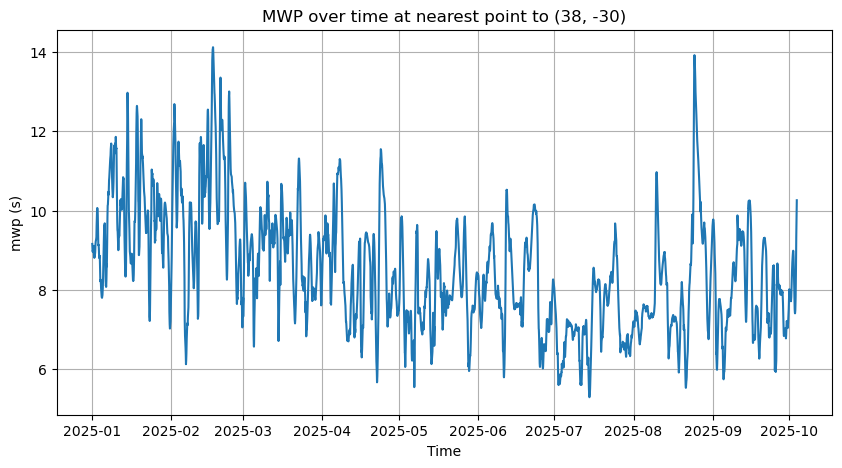

In [15]:
folder = "dataset_train"  # adjust your folder path
ds = xr.open_dataset(f"{folder}/combined.nc")

latitude = 38
longitude = -30
var = "mwp"  # or your desired variable

latitudes = ds['latitude'].values  # shape: (point,)
longitudes = ds['longitude'].values  # shape: (point,)

# Find the index of the point (exact match)
idx = np.where((latitudes == latitude) & (longitudes == longitude))[0]
if len(idx) == 0:
    print(f"Point ({latitude}, {longitude}) not found in dataset. Using nearest instead.")
    # Use nearest point if exact match not found
    lat_idx = np.argmin(np.abs(latitudes - latitude))
    lon_idx = np.argmin(np.abs(longitudes - longitude))
    point_idx = lat_idx if lat_idx == lon_idx else lat_idx  # fallback if structure is not regular
else:
    point_idx = idx[0]

# Get the variable values for the specific point
var_values = ds[var].isel(point=point_idx).values
# Get the corresponding times
times = ds['valid_time'].values

# Stack as a 2D array: columns are [time, value]
result_2d = np.column_stack((times.astype('O'), var_values.astype('O')))

# Example: plot time series at this point
plt.figure(figsize=(10,5))
plt.plot(ds['valid_time'].values, var_values) #, marker='.')
plt.xlabel('Time')
plt.ylabel(f"{var} ({ds[var].attrs.get('units', '')})")
plt.title(f"{var.upper()} over time at nearest point to ({latitude}, {longitude})")
plt.grid(True)
plt.show()

ds.close()

## 4.2 Spatial-Temporal Animation
Visualize the evolution of meteorological variables across the entire spatial domain over time using animated color maps.

In [17]:
# --------------------- Load Dataset ---------------------
var = "u10"  # variable to visualize

folder_train = "dataset_train"
folder_test = "dataset_test"
ds_train = xr.open_dataset(f"{folder_train}/combined.nc")
ds_test = xr.open_dataset(f"{folder_test}/combined.nc")

# Concatenate train and test datasets along 'point' dimension
ds_all = xr.concat([ds_train, ds_test], dim="point")

times = ds_all.valid_time.values
lats_all = ds_all.latitude.values
lons_all = ds_all.longitude.values
vals_all = ds_all[var].isel(valid_time=0).values

# Color map and scale
vmin, vmax = float(ds_all[var].min()), float(ds_all[var].max())
cmap = plt.get_cmap('turbo')

# Rectangle size (based on coordinate spacing)
lat_spacing = np.min(np.diff(np.unique(lats_all))) if len(np.unique(lats_all)) > 1 else 0.25
lon_spacing = np.min(np.diff(np.unique(lons_all))) if len(np.unique(lons_all)) > 1 else 0.25


# --------------------- SET UP CARTOPY MAP ---------------------

fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-33, -23, 35, 41], crs=ccrs.PlateCarree())  # Azores extent

# Map features - matching previous template style
ax.add_feature(cfeature.LAND, facecolor="#2d5a2d", alpha=0.8)  # Dark green land
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='#87ceeb', alpha=0.6)  # Light blue ocean

# Add gridlines with better formatting - matching previous template
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                  alpha=0.5, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# --------------------- DRAW INITIAL RECTANGLES (ALL POINTS) ---------------------

rects_all = []
for lon, lat, val in zip(lons_all, lats_all, vals_all):
    rect = patches.Rectangle(
        (lon - lon_spacing/2, lat - lat_spacing/2),
        lon_spacing, lat_spacing,
        facecolor=cmap((val - vmin) / (vmax - vmin)),
        edgecolor='white',
        linewidth=0.5,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)
    rects_all.append(rect)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label=f'{var} ({ds_all[var].attrs.get("units", "")})')
cbar.ax.tick_params(labelsize=10)

ax.set_title(f'{var.upper()} Temporal Animation - Azores Region\n{str(times[0])[:19]}', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# --------------------- ANIMATE OVER TIME ---------------------

import time

for t in range(len(times)):
    vals_all = ds_all[var].isel(valid_time=t).values
    for rect, val in zip(rects_all, vals_all):
        rect.set_facecolor(cmap((val - vmin) / (vmax - vmin)))

    ax.set_title(f'{var.upper()} Temporal Animation - Azores Region\n{str(times[t])[:19]}', 
                 fontsize=16, fontweight='bold', pad=20)
    display(fig)
    clear_output(wait=True)
    time.sleep(0.1)  # Small delay for better visualization

# Close datasets to free memory
ds_train.close()
ds_test.close()
ds_all.close()

KeyboardInterrupt: 